# Aplicación de Aprendizaje No Supervisado en Modelos Supervisados

## Descripción
Este notebook implementa un enfoque de aprendizaje no supervisado mediante el algoritmo **K-Means** para mejorar el desempeño de un modelo de clasificación supervisado.

## Algoritmo Utilizado
- **K-Means Clustering**: Se emplea para agrupar datos similares antes de aplicar el modelo supervisado.
- **Regresión Logística**: Modelo supervisado que se entrena con y sin preprocesamiento para comparar su desempeño.

## Impacto del Preprocesamiento
El impacto de la transformación se mide comparando métricas antes y después de aplicar K-Means. Se incluyen:
- **Accuracy Score**
- **Matriz de Confusión**
- **Curva ROC y AUC**
- **Reporte de Clasificación**

# Librerias
A continuación se muestran las librerias usadas en este código.

In [35]:
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score,  precision_recall_curve
)
import seaborn as sns
import numpy as np

# Descargar bases de datos
Se descargarán las bases de datos de kaggle

In [42]:
# Download latest version
#path = kagglehub.dataset_download("ak0212/average-daily-screen-time-for-children")

# Se mueve el archivo a la carpeta dentro de la carpeta Data dentro del proyecto.
df = pd.read_csv('Data/screen_time.csv')

Ahora se quiere hacer un analisis exploratorio de los datos para comprender que información se esta manejando.

Se conoce que la base de datos tiene las siguientes caracteristicas:
This datas real-world trends in children's screen time usage. It includes data on educational, recreational, and total screen time for children aged 5 to 15 years, with breakdowns by gender (Male, Female, Other/Prefer not to say) and day type (Weekday, Weekend) (Obtenido de Kaggle)

In [13]:
df.columns

Index(['Age', 'Gender', 'Screen Time Type', 'Day Type',
       'Average Screen Time (hours)', 'Sample Size'],
      dtype='object')

In [14]:
df.head()

,Age,Gender,Screen Time Type,Day Type,Average Screen Time (hours),Sample Size
0,5,Male,Educational,Weekday,0.44,500
1,5,Male,Recreational,Weekday,1.11,500
2,5,Male,Total,Weekday,1.55,500
3,5,Male,Educational,Weekend,0.50,500
4,5,Male,Recreational,Weekend,1.44,500


Se comparte información sobre las columnas que hay en la base de datos.

Age: Representa la edad del niño y van desde los 5 hasta los 15 años.

Gender: Solo hay 2 tipos, masculino (Male) y femenino (Female).

Screen Time Type: Para que estaban usando el dispositivo.

Day Type: Solo hay 2 valores, Weekday(entre semana) y Weekend(fin de semana).

Average Screen Time: Nos dice cuanto tiempo en promedio estuvieron enfrente de una pantalla

Sample Size: Cuantos niños se tomaron en cuenta para obtener dicha información.




### Agrupamiento de datos para clasificación

Ahora se busca agrupar los datos para poder conocer cuando se podría considerar adicto a la pantalla un niño pequeño y se descartará la columna samples porque podría llegar a afectar los algoritmos de agrupamientos y las columnas que son categoricas como Gender, Screen Time Type se harán númericas. Así se hará que si es male entonces será 0, si es Female será 1, si Other/Prefer not to say será 2, si Screen Time Type es Educational entonces será 0, si Screen Time Type es Recreational será 1, si Day Type es Weekday será 0 y si Day Type es Weekend será 1.

In [15]:
df.drop('Sample Size', axis=1, inplace=True)
df = df[df['Screen Time Type'] != 'Total']

df.replace({
    'Gender': {'Male': 1, 'Female': 0, 'Other/Prefer not to say':2},
    'Screen Time Type': {'Educational': 0, 'Recreational': 1},
    'Day Type': {'Weekday': 0, 'Weekend': 1}
}, inplace=True)

C:\Users\Wisp8\AppData\Local\Temp\ipykernel_13932\760874139.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({


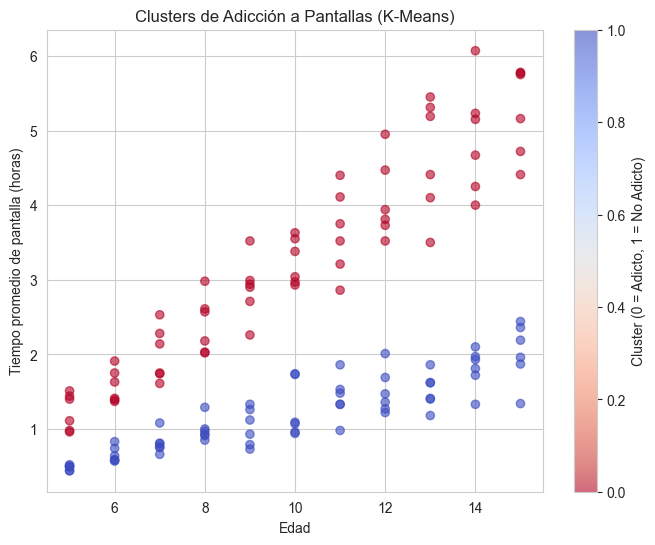

In [16]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df['Age'], df['Average Screen Time (hours)'], c= df['Cluster'], cmap='coolwarm_r', alpha=0.6) 
plt.xlabel("Edad")
plt.ylabel("Tiempo promedio de pantalla (horas)")
plt.title("Clusters de Adicción a Pantallas (K-Means)")
plt.colorbar(label="Cluster (0 = Adicto, 1 = No Adicto)")
plt.show()


Descripción de la Gráfica
La gráfica muestra los clusters de adicción a pantallas obtenidos mediante K-Means, donde se analiza la relación entre la edad y el tiempo promedio de pantalla (en horas).

Se utilizaron dos grupos (k=2) para clasificar a los niños en adictos y no adictos a las pantallas.

Rojo: Representa a los niños con mayor uso de pantallas (considerados "adictos").

Azul: Representa a los niños con menor uso de pantallas (considerados "no adictos").


Se observa que conforme aumenta la edad, también incrementa el tiempo promedio de pantalla. al igual que el grupo de niños más pequeños tiende a pasar menos tiempo en pantallas, mientras que los mayores tienen una mayor variabilidad en su tiempo de pantalla y a partir de los 10 años en adelante, los puntos rojos (adictos) son más frecuentes y se concentran en valores más altos de horas de pantalla.


Se concluye que la edad influye en la adicción a pantallas, con los niños mayores siendo más propensos a pasar más tiempo en dispositivos electrónicos.

In [17]:
df.groupby('Cluster')['Average Screen Time (hours)'].mean()

Cluster
0    3.262273
1    1.226970
Name: Average Screen Time (hours), dtype: float64

Se observa que si pasas en promedio 3.26 horas tienes una adiccion a la pantalla mientras que si tienes 1.22 horas se observa que no tienes dicha adicción.

Ahora se hará una regresión lógistica para realizar un algoritmo de aprendizaje supervisado que nos ayuda a dedicir si una persona es adicta o no.

### Modelo Supervisado
Ahora con los datos una vez categorizados se hará uso de un modelo supervisado de inteligencia artificial para la toma de desiciones. Se usará una regresión lógica dado que los datos son faciles de entender y han sido categorizadas para usarse de esta forma.

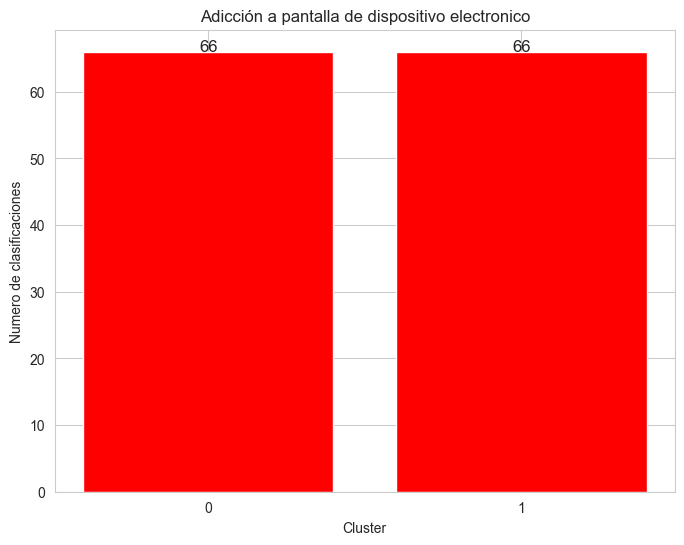

In [26]:
temp = df["Cluster"].value_counts()
graph = pd.DataFrame({'Cluster': temp.index, 'values': temp.values})

# Crear la gráfica de barras
plt.figure(figsize=(8, 6))
plt.bar(graph['Cluster'], graph['values'], color='red')

# Agregar etiquetas de valores
for i, v in enumerate(graph['values']):
    plt.text(graph['Cluster'][i], v, str(v), ha='center', fontsize=12)

# Configurar etiquetas y título
plt.xlabel('Cluster')
plt.ylabel('Numero de clasificaciones')
plt.title('Adicción a pantalla de dispositivo electronico')
plt.xticks(graph['Cluster'])  

# Mostrar la gráfica
plt.show()

Se observa que en los datos existe balanceo de información por lo que no hay problema para usar nuestro modelo de aprendizaje supervisado.

### Definicion de las variables caracteristicas (x) y variable objetivo (Y)
Una vez que se ha explorado la base de datos y se conoce que se quiere realizar es importante declarar las variables que serán usadas para predecir y la variable de respuesta para poder generar un modelo optimo.


In [32]:
target = 'Cluster'
predictors = ['Age', 'Gender', 'Screen Time Type', 'Day Type', 'Average Screen Time (hours)']

#### Division de la información

In [33]:
X = df[predictors]  # Variables predictoras
y = df[target]  # Variable objetivo

# Dividir en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [34]:
# Ver cuántas variables predictoras hay
num_features = X_train.shape[1]  # Esto es clave

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear y entrenar el modelo de regresión logística
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predecir con el conjunto de prueba
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")
print(f"ROC AUC Score: {roc_auc}")

Accuracy: 1.0
Confusion Matrix:
[[14  0]
 [ 0 13]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        13

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27

ROC AUC Score: 1.0


Ahora se quiere hacer una predicción con el modelo realizado. Se quiere evaluar un niño de 10 años, masculino (Male), que usa la pantalla para recreación (Recreational), en un día de fin de semana (Weekend), con un promedio de 4 horas de pantalla.

In [41]:
new_observation = pd.DataFrame({
    'Age': [10],
    'Gender': [0],  # Male → 0
    'Screen Time Type': [1],  # Recreational → 1
    'Day Type': [1],  # Weekend → 1
    'Average Screen Time (hours)': [4.0]
})

# Estandarizar la observación usando el scaler entrenado
new_observation_scaled = scaler.transform(new_observation)

# Hacer la predicción del cluster
predicted_cluster = model.predict(new_observation_scaled)
predicted_probability = model.predict_proba(new_observation_scaled)

print(f"\nPredicción para la nueva observación: Cluster {predicted_cluster[0]}")
print(f"Probabilidades por cluster: {predicted_probability[0]}")


Predicción para la nueva observación: Cluster 0
Probabilidades por cluster: [0.98715176 0.01284824]
